In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import PIL

In [2]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

In [3]:
DATA_DIR = 'bronze'
imgs = []
imgs_gray = []
for img_path in Path(DATA_DIR).iterdir(): 
    imgs.append(cv2.imread(str(img_path)))
    imgs_gray.append(cv2.imread(str(img_path), 0))

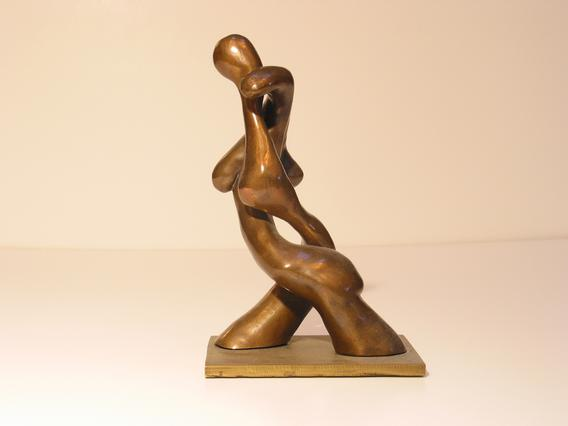

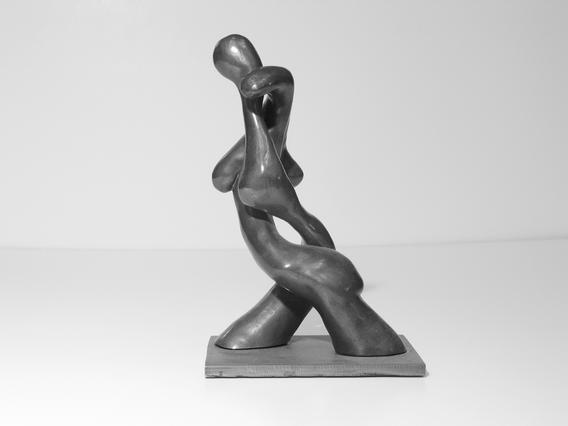

In [4]:
imshow(imgs[0])
imshow(imgs_gray[0])

In [5]:
result = np.zeros_like(imgs[0], dtype=np.uint16)
for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        k = np.argmax([x[i][j] for x in imgs_gray])
        result[i][j] = imgs[k][i][j]

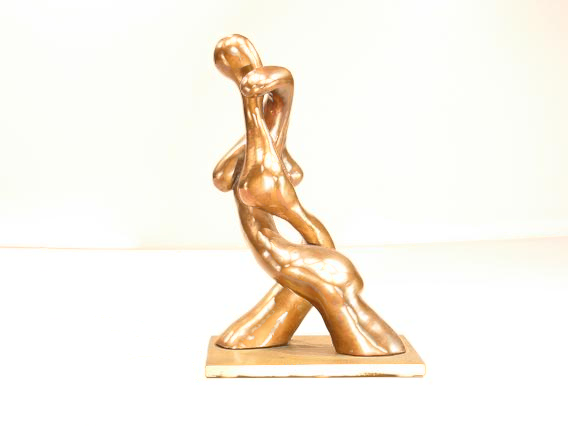

In [6]:
imshow(result)

In [7]:
result = np.zeros_like(imgs[0])
for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        k = np.argmax([x[i][j] for x in imgs_gray])
        s = np.zeros(3, dtype=np.uint16)
        for k in range(len(imgs)):
            s += imgs[k][i][j]
        result[i][j] = s / len(imgs)
        

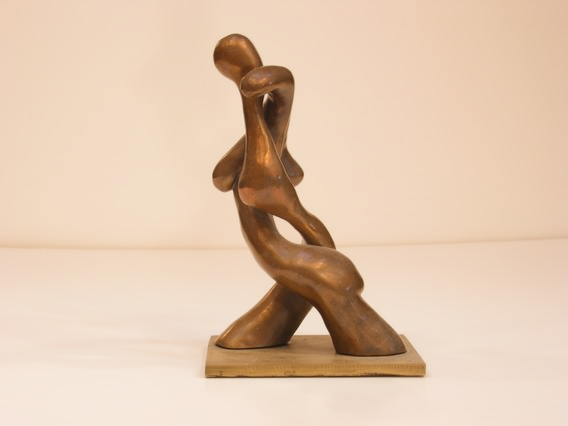

In [8]:
imshow(result)

In [9]:
result = np.zeros_like(imgs[0])
for i in range(result.shape[0]):
    for j in range(result.shape[1]):
        k = np.argmax([x[i][j] for x in imgs_gray])
        s = np.zeros(3, dtype=np.uint16)
        ws = sum([x[i][j] for x in imgs_gray])
        for k in range(len(imgs)):
            s = s + (imgs_gray[k][i][j] / ws) * imgs[k][i][j]
        result[i][j] = s

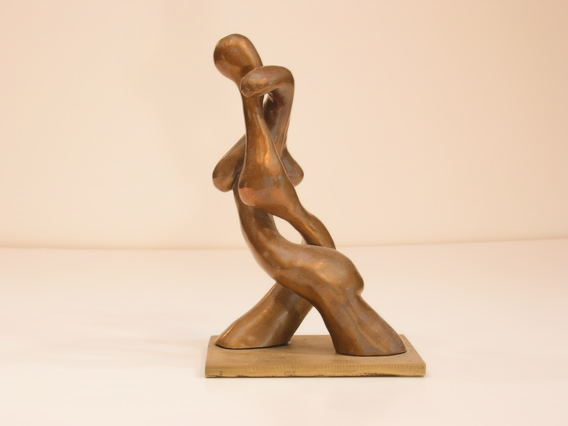

In [10]:
imshow(result)